#Tytanic_Data_Analysis

## Importing all the required Libreries 

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Reading data using read_csv() method

In [14]:
data=pd.read_csv("/content/train.csv")
data.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## checking for NAN values

In [19]:
data.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

## EDA (Exploratory Data Analysis)

In [20]:
data.drop(["PassengerId","Cabin","Name","Ticket"],inplace=True,axis=1)
data['Age']=data['Age'].fillna(data['Age'].median())
data['Embarked']=data['Embarked'].fillna(data['Embarked'].mode()[0])
data['Fare'][data['Fare']>400]

258    512.3292
679    512.3292
737    512.3292
Name: Fare, dtype: float64

## creating Dummy Variables

In [21]:
data["Sex"]=data["Sex"].map({"female":0,"male":1})
data=pd.get_dummies(data,drop_first=True)
data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,0,1
1,1,1,0,38.0,1,0,71.2833,0,0
2,1,3,0,26.0,0,0,7.9250,0,1
3,1,1,0,35.0,1,0,53.1000,0,1
4,0,3,1,35.0,0,0,8.0500,0,1
5,0,3,1,28.0,0,0,8.4583,1,0
6,0,1,1,54.0,0,0,51.8625,0,1
7,0,3,1,2.0,3,1,21.0750,0,1
8,1,3,0,27.0,0,2,11.1333,0,1
9,1,2,0,14.0,1,0,30.0708,0,0


## visualizing data to see for the relation among the variables

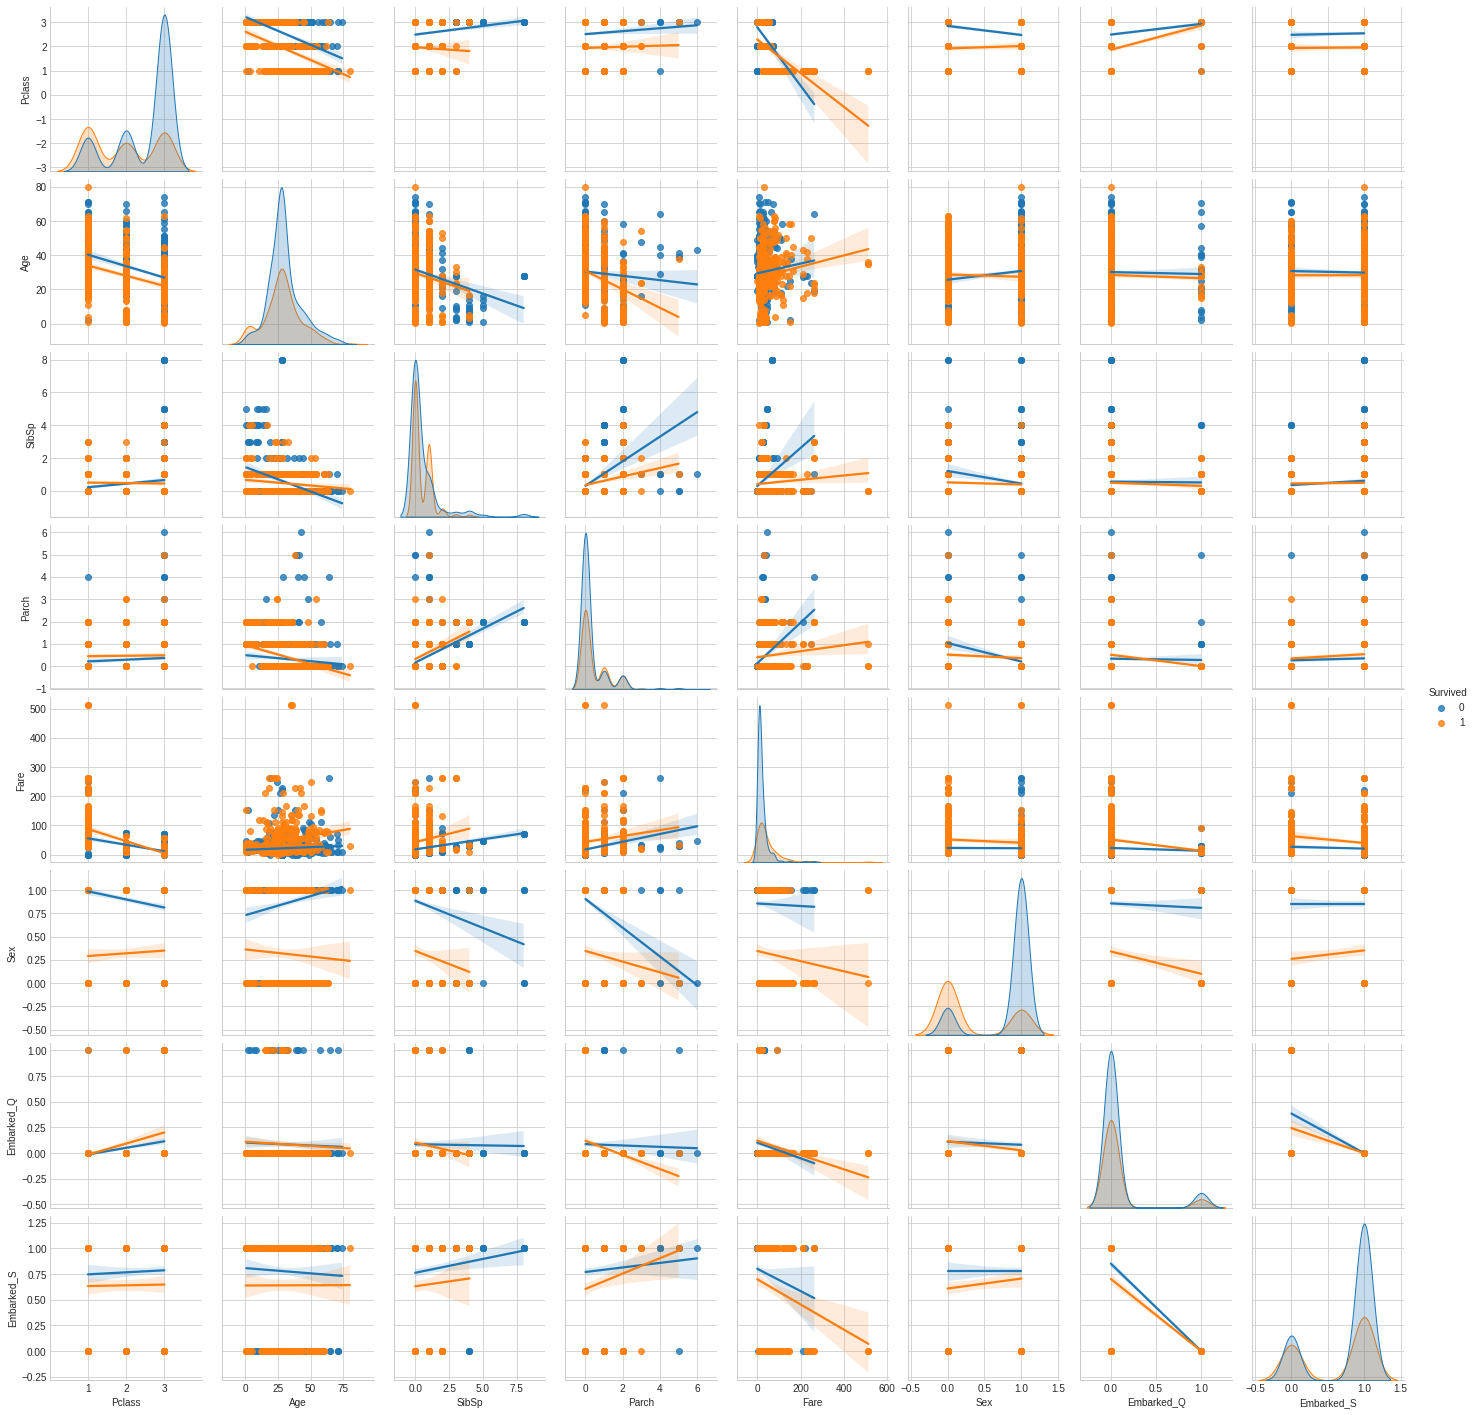

In [22]:
sns.pairplot(data,vars=["Pclass","Age","SibSp","Parch","Fare","Sex","Embarked_Q","Embarked_S"],kind="reg",hue="Survived")

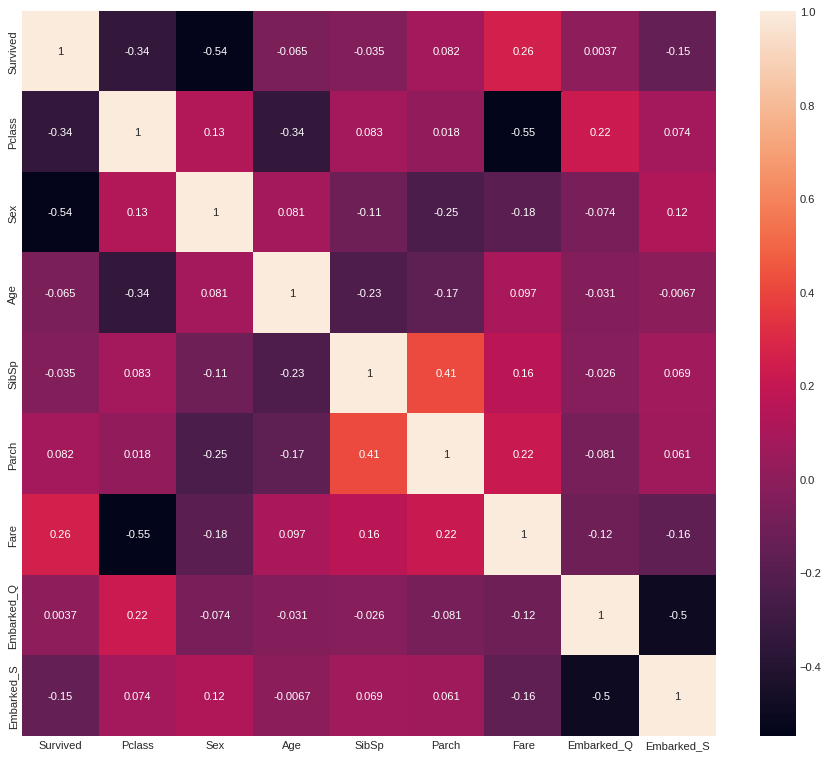

In [26]:
correlation=data.corr()
plt.figure(figsize=(14,12),dpi=80)
sns.heatmap(correlation,annot=True)

In [27]:
data.drop(["Fare","Embarked_Q","SibSp"],inplace=True,axis=1)
data.head()

,Survived,Pclass,Sex,Age,Parch,Embarked_S
0,0,3,1,22.0,0,1
1,1,1,0,38.0,0,0
2,1,3,0,26.0,0,1
3,1,1,0,35.0,0,1
4,0,3,1,35.0,0,1


# Preprocessing Step

In [28]:
mm_scale=MinMaxScaler()
data_scaled=pd.DataFrame(mm_scale.fit_transform(data),columns=data.columns)
data_scaled.head()

,Survived,Pclass,Sex,Age,Parch,Embarked_S
0,0.0,1.0,1.0,0.271174,0.0,1.0
1,1.0,0.0,0.0,0.472229,0.0,0.0
2,1.0,1.0,0.0,0.321438,0.0,1.0
3,1.0,0.0,0.0,0.434531,0.0,1.0
4,0.0,1.0,1.0,0.434531,0.0,1.0


In [29]:
yScaled=data["Survived"]
xScaled=data_scaled.drop("Survived",axis=1)
xScaled.head()

,Pclass,Sex,Age,Parch,Embarked_S
0,1.0,1.0,0.271174,0.0,1.0
1,0.0,0.0,0.472229,0.0,0.0
2,1.0,0.0,0.321438,0.0,1.0
3,0.0,0.0,0.434531,0.0,1.0
4,1.0,1.0,0.434531,0.0,1.0


# Feature Selection 

In [33]:
lm=LinearRegression()
lm.fit(xScaled,yScaled)
rfe=RFE(lm,4)
rfe=rfe.fit(xScaled,yScaled)
list(zip(xScaled.columns,rfe.support_,rfe.ranking_))

TypeError: ignored

In [34]:
vif=pd.DataFrame()
vif['features']=xScaled.columns
vif['VIF']=[variance_inflation_factor(xScaled.values,i) for i in range(xScaled.shape[1])]
vif['VIF']=round(vif['VIF'],3)
vif=vif.sort_values(by="VIF",ascending=False)
vif

,features,VIF
4,Embarked_S,3.347
2,Age,3.191
1,Sex,3.013
0,Pclass,2.755
3,Parch,1.250


In [35]:
xc=sm.add_constant(xScaled)
lm=sm.OLS(yScaled,xc).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     113.5
Date:                Fri, 28 Jan 2022   Prob (F-statistic):           1.07e-92
Time:                        19:10:43   Log-Likelihood:                -401.25
No. Observations:                 891   AIC:                             814.5
Df Residuals:                     885   BIC:                             843.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1682      0.051     23.123      0.0

In [36]:
xc.drop("Parch",inplace=True,axis=1)
xc.drop("const",inplace=True,axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


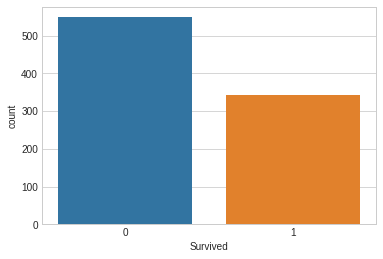

In [37]:
sns.countplot(yScaled)

# Model (DecisionTreeClassifier)

In [39]:
model=DecisionTreeClassifier()
model.fit(xc,yScaled)

DecisionTreeClassifier()

## importing Test data

In [40]:
test=pd.read_csv("/content/test.csv")
test.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


## cleaning test data using EDA

In [41]:
passengerId=test['PassengerId']
test.drop(["PassengerId","Name","SibSp","Parch","Ticket","Fare","Cabin"],inplace=True,axis=1)
test.head()

,Pclass,Sex,Age,Embarked
0,3,male,34.5,Q
1,3,female,47.0,S
2,2,male,62.0,Q
3,3,male,27.0,S
4,3,female,22.0,S


In [42]:
test['Sex']=test['Sex'].map({"female":0,"male":1})
test=pd.get_dummies(test,drop_first=True)
test.head()

,Pclass,Sex,Age,Embarked_Q,Embarked_S
0,3,1,34.5,1,0
1,3,0,47.0,0,1
2,2,1,62.0,1,0
3,3,1,27.0,0,1
4,3,0,22.0,0,1


In [43]:
test.drop("Embarked_Q",inplace=True,axis=1)
test["Age"]=test["Age"].fillna(test["Age"].median())
test_scaled=pd.DataFrame(mm_scale.fit_transform(test),columns=test.columns)
test_scaled.head()

,Pclass,Sex,Age,Embarked_S
0,1.0,1.0,0.452723,0.0
1,1.0,0.0,0.617566,1.0
2,0.5,1.0,0.815377,0.0
3,1.0,1.0,0.353818,1.0
4,1.0,0.0,0.287881,1.0


# Predicting Model Prediction using test data

In [44]:
pred=model.predict(test_scaled)
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [45]:
pred_data=pd.DataFrame(pred,columns=['Survived'])
data_target=pd.concat([passengerId,pred_data],axis=1)
data_target

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


# Final Conclusion

In [46]:
data_target.to_csv('my_submission.csv',index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
